In [41]:
import pandas as pd
import numpy as np
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import utils as u
import custom_transformers as ct

In [42]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [44]:
sample_size = 2
random_seed = 42
test_size = 0.3
cv = 3

In [45]:
queries = u.get_queries('queries')

In [46]:
bq_client = bigquery.Client()

In [47]:
data = u.get_data(queries, 'training_data.sql', bq_client)

In [48]:
data.head()

,ad_id,apt_id,time_s,property_type_apartment,new_building,construction_year,ownership_full,floor,num_bedrooms,primary_size,address,price_per_sq_m
0,154481527,None,NaN,1,0,2006.0,0,7.0,3.0,95.0,Rubina Ranas gat...,99772.0
1,154434920,None,NaN,1,0,1979.0,0,1.0,2.0,72.0,"Grefsenveien 28,...",69059.0
2,154516679,None,NaN,1,0,1918.0,0,2.0,2.0,78.0,"Haralds vei 6, 0...",86763.0
3,147803036,None,NaN,0,0,2010.0,1,NaN,4.0,188.0,"Dalsveien 56 D, ...",70699.0
4,131680669,2,3769.0,0,1,2019.0,1,1.0,3.0,91.0,"Jonsbråtavegen, ...",43091.0


In [49]:
data.shape

(7027, 12)

In [50]:
data = data[data.address.notnull()].copy()

In [51]:
data_sample = data.groupby('ad_id').apply(lambda obj: obj.sample(n=sample_size, random_state=random_seed)
                                          if len(obj) > sample_size
                                          else obj.sample(len(obj)))

In [52]:
data = data.set_index(['ad_id', 'apt_id'], drop=True)

In [53]:
data.shape

(7027, 10)

In [54]:
data_enrichment = [('extract_post_code', ct.PostCodeExtractor()),
                   ('add_area_name', ct.PostCodeEnricher()),
                   ('add_gmaps_data', ct.GmapsPlaceEnricher()),
                   ('add_nhs_data', ct.NhsDataEnricher()),
                   # ('add_historic_data', ct.HistoricDataEnricher()),
                   ('remove_helper_columns', ct.AuxiliaryColumnRemover()),
                   ('impute_features', ct.CustomImputer())]

model_steps = [('scale', preprocessing.MinMaxScaler()),
               ('normalize', preprocessing.Normalizer()),
               ('model', 'passthrough')]

models = [ensemble.AdaBoostRegressor(random_state=random_seed),
          linear_model.LinearRegression()]

model_params = {'model': models}

In [55]:
enrichment_pipeline = pipeline.Pipeline(data_enrichment)

In [56]:
model_pipeline = pipeline.Pipeline(model_steps)

In [57]:
data.isna().sum(axis=0).sort_values(ascending=False)[:20]

floor                      1060
time_s                      641
num_bedrooms                149
price_per_sq_m                0
address                       0
primary_size                  0
ownership_full                0
construction_year             0
new_building                  0
property_type_apartment       0
dtype: int64

In [58]:
X = data.drop('price_per_sq_m', axis=1)
y = data.price_per_sq_m

In [59]:
X = enrichment_pipeline.fit_transform(X)

In [60]:
X.head()

,,time_s,property_type_apartment,new_building,construction_year,ownership_full,floor,num_bedrooms,primary_size,num_lodging_places,num_dining_places,uni_graduates
ad_id,apt_id,,,,,,,,,,,
154481527,NaN,14400.0,1,0,2006.0,0,7.0,3.0,95.0,6.0,3.0,0.64
154434920,NaN,14400.0,1,0,1979.0,0,1.0,2.0,72.0,1.0,1.0,0.76
154516679,NaN,14400.0,1,0,1918.0,0,2.0,2.0,78.0,0.0,0.0,0.68
147803036,NaN,14400.0,0,0,2010.0,1,1.0,4.0,188.0,0.0,0.0,0.77
131680669,2,3769.0,0,1,2019.0,1,1.0,3.0,91.0,0.0,0.0,0.35


In [61]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_seed)

In [62]:
X_train.shape

(4918, 11)

In [63]:
grid = model_selection.GridSearchCV(model_pipeline, cv=cv, n_jobs=1, param_grid=model_params, scoring='neg_mean_absolute_error')

In [64]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('normalize',
                                        Normalizer(copy=True, norm='l2')),
                                       ('model', 'passthrough')],
                                verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'model': [AdaBoostRegressor(base_estimator=None,
                                                     learning_rate=1.0,
                                                     loss='linear',
                                                     n_estimators=50,
                                                     random_state=42),
                                   LinearRegression(copy_X=True,
                

In [65]:
grid.best_score_

-10833.89899384934

In [66]:
final_model = grid.best_estimator_

In [67]:
final_model

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [68]:
def get_learning_curves(estimator, X, y, train_sizes=np.arange(0.1, 1.1, 0.1), score='neg_mean_absolute_error', cv=5):
    train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator, X, y, train_sizes=train_sizes, scoring=score, cv=cv)
    curve_data = pd.DataFrame(columns = range(train_scores.shape[1]))
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        curve_data = curve_data.append(frame, ignore_index = True)
    curve_data = curve_data.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')
    return curve_data


def get_cv_res(estimator, X, y, score=['neg_mean_absolute_error'], cv=5):
    cross_val = model_selection.cross_validate(estimator, X, y, scoring=score, cv=cv)
    return cross_val


def print_cv_res(cross_val):
    for key, val in cross_val.items():
        print('Mean {}, {:.2f}'.format(key, val.mean()))

In [69]:
learning_curve_res = get_learning_curves(final_model, X_train, y_train, score='neg_mean_absolute_error', cv=cv)

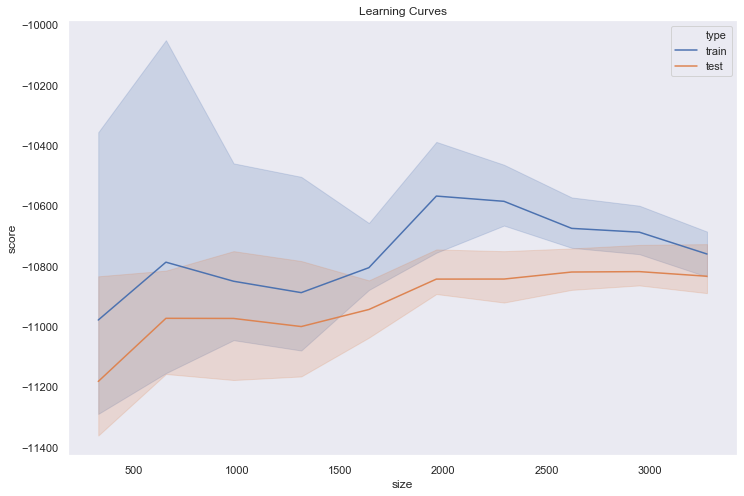

In [70]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

In [71]:
cv_res = get_cv_res(final_model,
                    X_train,
                    y_train,
                    score=['neg_mean_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'],
                    cv=cv)

In [72]:
print_cv_res(cv_res)

Mean fit_time, 0.00
Mean score_time, 0.00
Mean test_neg_mean_absolute_error, -10833.92
Mean test_r2, 0.59
Mean test_explained_variance, 0.59
Mean test_max_error, -125189.78


In [73]:
pred = final_model.predict(X_test)

In [74]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

In [75]:
y_pred.head()

ad_id      apt_id 
119623530  B H0501    69239.505680
153237766  NaN        99199.104451
152654528  NaN        29556.634353
152664583  NaN        34142.023491
144534545  2202       62909.948324
Name: predicted, dtype: float64

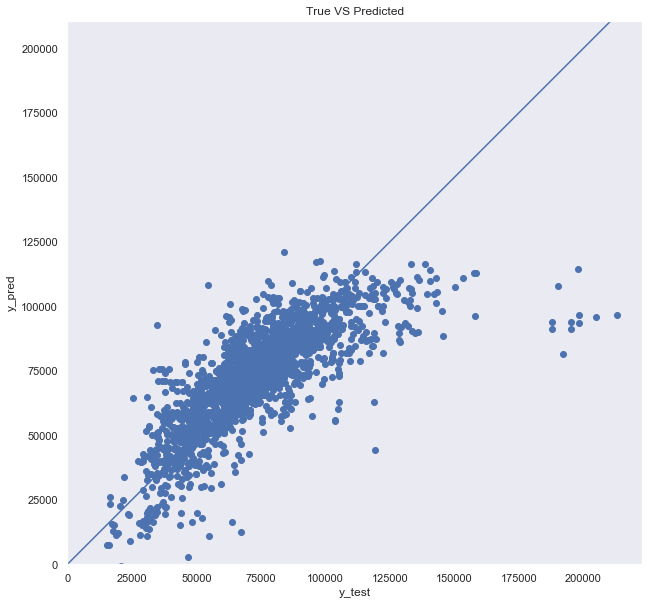

In [76]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-5e7, 5e7], [-5e7, 5e7])
plt.title('True VS Predicted')
plt.show()

In [77]:
to_plot = X_test.join(y_pred).join(y_test)
to_plot['pred_diff'] = to_plot['predicted'] - to_plot['price_per_sq_m']

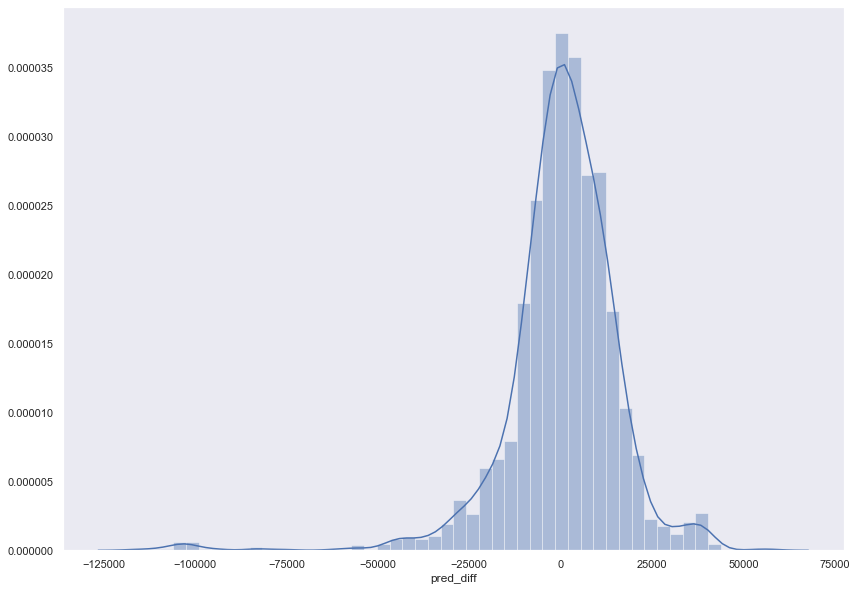

In [78]:
sns.distplot(to_plot.pred_diff)

In [79]:
if isinstance(final_model.named_steps['model'], linear_model.LinearRegression):
    feature_importances = pd.Series(final_model.named_steps['model'].coef_, index=X.columns)
    xlabel = 'feature coefficient'
elif isinstance(final_model.named_steps['model'], ensemble.AdaBoostRegressor):
    feature_importances = pd.Series(final_model.named_steps['model'].feature_importances_, index=X.columns)
    xlabel = 'feature importance'

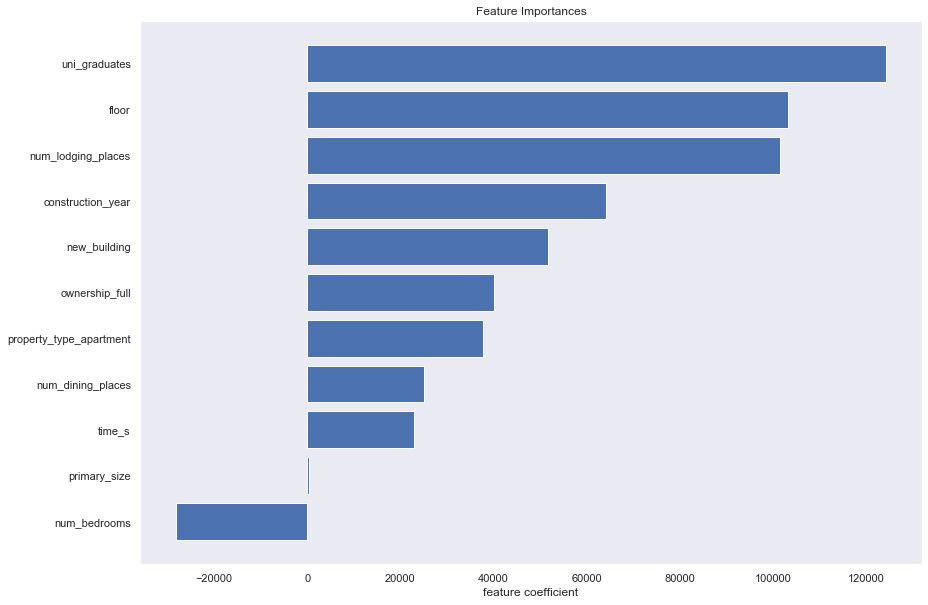

In [80]:
to_plot = feature_importances.sort_values()
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.xlabel(xlabel)
plt.show()